## Enviorment

In [2]:
!whoami

michael_zl_prime


In [3]:
!gcloud auth list

                  Credentialed Accounts
ACTIVE  ACCOUNT
*       312164605303-compute@developer.gserviceaccount.com

To set the active account, run:
    $ gcloud config set account `ACCOUNT`



In [4]:
#test which virtualenv running in
import sys
sys.prefix

'/usr'

In [5]:
#start tensor board
# must run 
#/usr/local/bin/tensorboard serve --logdir gs://dl_training_results/tensorboard --port 8889 --bind_all --purge_orphaned_data True > /tmp/tensorboard_run.log

---

In [6]:
import ipywidgets as widgets

In [7]:
import datetime
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from google.cloud import storage

from config import TRANSFORMED_TRAIN_ANNOTATIONS_PATH,TRANSFORMED_VALIDATION_ANNOTATIONS_PATH,IMAGE_SIZE
from models.six_stage_linear_model import ModelMaker
import dataset_functions
import visualizations as v

In [8]:
tf.version.VERSION

'2.1.0-dev20191124'

In [9]:
#Training config, can be moved later to main config
CACHE=True
CACHE_RAMFS=False #uses a ramfs file to force using main memory
  #must be small if caching

SHUFFLE=True
PREFETCH=10  #size of prefetch size, 0 to disable

USING_TPU=0
if USING_TPU:
    BATCH_SIZE=128
else:
    BATCH_SIZE=2

TRAINING_EPOCHS=100

In [10]:
DATASET_SIZE=56000 #exact size not critical
DATASET_VAL_SIZE=2500 

In [11]:
steps_per_epoch=int(DATASET_SIZE/BATCH_SIZE)

In [12]:
if USING_TPU:
    tpu_ip='10.0.3.2'
    # !!!MAKE SURE THE TPU ADDRESS IS CORRECT!!
    # 1.ip must be correct
    # 2.tpu must be turned on!
    # 3.version must be 'nightly-2.x'
    # 4.tpu must be reachable (check with gce netowrking/connectivity test)
    # if not this will hang
    tpu_address = 'grpc://'+tpu_ip+':8470'
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)

---
Caching using ramfs (irrelevant for tpu)

In [13]:
if CACHE_RAMFS:
    !mkdir /tmp/ramdisk
    !sudo umount /tmp/ramdisk
    !sudo mount -t ramfs -o size=512m ramfs /tmp/ramdisk
    !sudo chown $LOGNAME:$LOGNAME /tmp/ramdisk

In [14]:
if CACHE_RAMFS:
    cache_loc="/tmp/ramdisk/cache_t"
    cache_v_loc="/tmp/ramdisk/cache_v"
else:
    cache_loc=None
    cache_v_loc=None

In [15]:
cache_loc

---
# Make dataset

In [16]:
label_transformer=dataset_functions.LabelTransformer()
@tf.function
def make_label_tensors(elem):
    """Transforms a dict data element:
    1.Read jpg to tensor 
    1.1 Resize img to correct size for network
    2.Convert keypoints to correct form label tensor
    3.Convert joints to correct form label tensor
    outputs a tuple data element"""
    
    idd=elem['id']
    kpt_tr=label_transformer.keypoints_spots_vmapfn(elem['kpts'])
    paf_tr=label_transformer.joints_PAFs(elem['joints'])
    
    image_raw=elem["image_raw"]
    image=tf.image.decode_jpeg(image_raw,channels=3)
    image=tf.image.convert_image_dtype(image,dtype=tf.float32)
    image=tf.image.resize(image,IMAGE_SIZE)
    return image,(paf_tr,kpt_tr),idd

In [17]:
@tf.function
def place_training_labels(image,labels,idd):
    """Disterbutes labels into the correct configuration for the model, ie 4 PAF stage, 2 kpt stages
    must match the model"""
    paf_tr=labels[0]
    kpt_tr=labels[1]
    return image,(paf_tr,paf_tr,paf_tr,paf_tr,kpt_tr,kpt_tr) #this should match the model outputs, and is different for each model

Read and Parse the TFrecords

----
figure out GCS storage


In [18]:
train_prefix=TRANSFORMED_TRAIN_ANNOTATIONS_PATH.split(os.sep)[-1]
val_prefix=TRANSFORMED_VALIDATION_ANNOTATIONS_PATH.split(os.sep)[-1]

In [19]:
bucket_name="datasets_bucket_a"
gs_prefix="gs://"

In [20]:
storage_client = storage.Client() #must have apropriate authenitication to work 

train_blobs = storage_client.list_blobs(bucket_name,prefix=train_prefix)
val_blobs = storage_client.list_blobs(bucket_name,prefix=val_prefix)

In [21]:
tfrecord_files_train=[gs_prefix+bucket_name+'/'+blob.name for blob in train_blobs]
tfrecord_files_val=[gs_prefix+bucket_name+'/'+blob.name for blob in val_blobs]

In [22]:
#tfrecord_files_train

Make training dataset

In [23]:
ds = tf.data.TFRecordDataset(tfrecord_files_train)

In [24]:
TF_parser=dataset_functions.TFrecordParser() #used for 

#order of transformations is critical!

#TFrecord files to raw format
ds = tf.data.TFRecordDataset(tfrecord_files_train) #numf reads can be put here, but I don't think I/O is the bottleneck

#raw format to imgs,tensors(coords kpts)
ds=ds.map(TF_parser.read_tfrecord)

#cache  ,caching is here before decompressing jpgs and label tensors (should be ~9GB) , (full dataset should be ~90, cache later if RAM aviable)
if CACHE: ds=ds.cache()
if SHUFFLE: ds=ds.shuffle(100)    
    
#Augmentation should be here, to operate on smaller tensors
    
#imgs,tensors to label_tensors (46,46,17/38)
ds=ds.map(make_label_tensors)
#imgs,label_tensors arrange for model outputs
ds=ds.map(place_training_labels) 

#batch
ds=ds.batch(BATCH_SIZE)
#repeat
ds=ds.repeat()
#prefetch
if PREFETCH: ds=ds.prefetch(PREFETCH)

Make validation dataset

In [25]:
TF_parser=dataset_functions.TFrecordParser() #used for 

#order of transformations is critical!

#TFrecord files to raw format
ds_v = tf.data.TFRecordDataset(tfrecord_files_val) #numf reads can be put here, but I don't think I/O is the bottleneck
#raw format to imgs,tensors(coords kpts)
ds_v=ds_v.map(TF_parser.read_tfrecord)   

#cache  
if CACHE: ds_v=ds_v.cache()
    
#imgs,tensors to label_tensors (46,46,17/38)
ds_v=ds_v.map(make_label_tensors)
#imgs,label_tensors arrange for model outputs
ds_v=ds_v.map(place_training_labels) 
#batch
ds_v=ds_v.batch(BATCH_SIZE)


Examine datasets

In [25]:
#st=next(iter(ds))
#st
#st_v=next(iter(ds_v))
#v.show_pafs_kpts_img()
print(ds)
print(ds_v)

<PrefetchDataset shapes: ((None, 368, 368, 3), ((None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 17), (None, 46, 46, 17))), types: (tf.float32, (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>
<BatchDataset shapes: ((None, 368, 368, 3), ((None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 17), (None, 46, 46, 17))), types: (tf.float32, (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>


---
# Callbacks
**Checkpoints**

In [26]:
#local dir for CPU/GPU training
#checkpoints_dir='./checkpoints'
#!mkdir checkpoints
#gcs dir for TPU training
checkpoints_dir='gs://dl_training_results/checkpoints'
#make sure the directory exists, if not make it.

In [27]:
import datetime
now=datetime.datetime.now().strftime("%d%a%m%y-%H%M")


In [28]:
t=datetime.datetime.now()
now=t.strftime("%a%d%m%y-%H%M")
checkpoints_path = checkpoints_dir+"/ModelWeights-"+datetime.datetime.now().strftime("%d%a%m%y-%H%M")+"-{epoch:04d}.ckpt" 
checkpoints_path

'gs://dl_training_results/checkpoints/ModelWeights-01Sun1219-0027-{epoch:04d}.ckpt'

In [29]:
#if this fails, the checkpointing won't work
!touch /tmp/test
!gsutil cp /tmp/test {checkpoints_dir}/test
!gsutil rm {checkpoints_dir}/test

Copying file:///tmp/test [Content-Type=application/octet-stream]...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Removing gs://dl_training_results/checkpoints/test...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              


In [30]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoints_path,
                                             save_weights_only=True,
                                             verbose=1)

**Logging**

In [31]:
logging_dir='gs://dl_training_results/Log'+datetime.datetime.now().strftime("%d%a%m%y-%H%M")+".csv"
csv_logger = tf.keras.callbacks.CSVLogger(logging_dir,append=True)  #doesn't work!

In [32]:
#if this fails, the checkpointing won't work
!touch /tmp/test
!gsutil cp /tmp/test {logging_dir}/test
!gsutil rm {logging_dir}/test

Copying file:///tmp/test [Content-Type=application/octet-stream]...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Removing gs://dl_training_results/Log01Sun1219-0027.csv/test...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              


**TensorBoard**

In [33]:
tesnroboard_base_dir='gs://dl_training_results/tensorboard/'
tensorboard_dir=tesnroboard_base_dir+datetime.datetime.now().strftime("%a%d%m%y-%H%M")

In [34]:
#!gsutil -m rm -r {tesnroboard_base_dir}

In [35]:

tensorboard_callback=tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_dir
    #,update_freq=5000 #to update sooner than every epoch
)

In [36]:
#if this fails, the checkpointing won't work
!touch /tmp/test
!gsutil cp /tmp/test {tensorboard_dir}/test
!gsutil rm {tensorboard_dir}/test

Copying file:///tmp/test [Content-Type=application/octet-stream]...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Removing gs://dl_training_results/tensorboard/Sun011219-0027/test...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              


In [37]:
#the command to run tensorboard
#tensorboard serve --logdir gs://dl_training_results/tensorboard --port 8889 --bind_all

In [38]:
#HYPERPARAMETERS
#adam_learning_rate=0.001  #for reference
base_learning_rate=0.001
lr_scheduele=np.zeros(1000)
lr_scheduele[:3]=0.2
lr_scheduele[3:20]=3
lr_scheduele[20:40]=2
lr_scheduele[40:60]=1
lr_scheduele[60:]=0.1
lr_scheduele*=base_learning_rate

def get_lr(epoch):
    return lr_scheduele[epoch]

# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch,train_model.optimizer.lr.numpy()))


In [39]:
callbacks=[
    cp_callback
    #,csv_logger  #should open an issue on that
    ,tensorboard_callback
    ,tf.keras.callbacks.LearningRateScheduler(get_lr)
    ,PrintLR()
    ,tf.keras.callbacks.TerminateOnNaN()
]

---
# Model

In [40]:
class AnalogRecall(tf.keras.metrics.Metric):
    """This metric returns the overlap of the true gaussian 'islands' and the predicted ones"""
    def __init__(self, name='analog_recall',thershold=0.01, **kwargs):
        super(AnalogRecall, self).__init__(name=name, **kwargs)
        self.mean = self.add_weight(name='mean', initializer='zeros')
        self.thershold=thershold
    
    
    def update_state(self, y_true, y_pred,**kwargs):     
        
        true_island_sum=tf.reduce_sum(tf.where(y_true>self.thershold,y_true,0)) #get sum of the true island
        true_island_size=tf.cast(tf.math.count_nonzero(y_true>self.thershold),dtype=tf.float32) #get size of the island   
        mean_island_true=true_island_sum/true_island_size #average island value
               
        err=y_true-y_pred  #get all error
        recall_err=tf.where(err>0,err,0)  #get only recall error, the parts where prediction is missing
        recall_err_sum=tf.reduce_sum(recall_err)        
        err_island_size=tf.cast(tf.math.count_nonzero(y_true>self.thershold),tf.float32)  #get size of the islands above thershold
        
        mean_island_recall_err=recall_err_sum/err_island_size  #mean of the error 
        
        value=1-mean_island_recall_err/mean_island_true #the 1- converts it to recall accuracy onstead of err        
        self.mean.assign_add(value)
        
    def result(self):
        return self.mean

## Load weights

In [41]:
#delete checkpoints if needed
#!gsutil -m rm -r {checkpoints_dir}

In [42]:
chekpoints_bucket="dl_training_results"
for i,f in enumerate( storage_client.list_blobs(chekpoints_bucket,prefix='checkpoints')):
    if f.name.endswith('.index'):
        print("gs://"+chekpoints_bucket+"/"+f.name[:-6])

gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-1956-0001.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2025-0001.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2048-0001.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2048-0002.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2048-0003.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2048-0004.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2048-0005.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2231-0004.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2244-0004.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2244-0005.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2244-0006.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2244-0007.ckpt
gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2244-0008.ckpt

In [51]:
cpkt="gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2244-0007.ckpt"
starting_epoch=7

In [44]:
# !mkdir /tmp/ckpt
# !gsutil cp "gs://dl_training_results/checkpoints/ModelWeights-30(Sat)1119-2244-0006.*" /tmp/ckpt/
# cpkt="/tmp/ckpt/ModelWeights-30(Sat)1119-2244-0006.ckpt"

In [45]:
load=widgets.Checkbox(
    value=False,
    description='Load weights'
)
load

Checkbox(value=False, description='Load weights')

In [52]:
model_maker=ModelMaker() #must be outside scope to keep the graph clean
def define():
    train_model,test_model=model_maker.create_models()
    
    #this must match the model output order
    metrics={'stage1paf_output':  [tf.keras.metrics.MeanAbsoluteError()]
         ,'stage2paf_output':  [tf.keras.metrics.MeanAbsoluteError()]
         ,'stage3paf_output':  [tf.keras.metrics.MeanAbsoluteError()]
         ,'stage4paf_output':  [tf.keras.metrics.MeanAbsoluteError()]
         ,'stage5heatmap_output': [
             #AnalogRecall(),
             tf.keras.metrics.MeanAbsoluteError()]    
         ,'stage6heatmap_output': [
             #AnalogRecall(),
             tf.keras.metrics.MeanAbsoluteError()]
        }
    
    train_model.compile(optimizer=tf.keras.optimizers.Adam()
                    ,loss=tf.keras.losses.MeanSquaredError(name="MSE_loss")
                    ,metrics=metrics                    
                   )
    return train_model,test_model

if USING_TPU:
    with strategy.scope():
        train_model,test_model=define()
        if (load.value):
            train_model.load_weights(cpkt)
else:
    train_model,test_model=define()
    if (load.value):
        train_model.load_weights(cpkt)

---
Actually training

In [53]:
train_history=train_model.fit(
    ds
    ,epochs=10
    ,steps_per_epoch=steps_per_epoch
    ,validation_data=ds_v
    ,callbacks=callbacks
    ,initial_epoch=starting_epoch
)

Train for 437 steps

Learning rate for epoch 7 is 0.003000000026077032
Epoch 8/10
281/437 [==================>...........] - ETA: 3:25 - loss: 3513169370137980.5000 - stage1paf_output_loss: 1.5843 - stage2paf_output_loss: 1785.4202 - stage3paf_output_loss: 796023.0625 - stage4paf_output_loss: 377732320.0000 - stage5heatmap_output_loss: 162006532096.0000 - stage6heatmap_output_loss: 3513007028043776.0000 - stage1paf_output_mean_absolute_error: 0.0245 - stage2paf_output_mean_absolute_error: 0.6583 - stage3paf_output_mean_absolute_error: 18.2988 - stage4paf_output_mean_absolute_error: 463.9840 - stage5heatmap_output_mean_absolute_error: 12686.9766 - stage6heatmap_output_mean_absolute_error: 1711755.5000
Epoch 00008: saving model to gs://dl_training_results/checkpoints/ModelWeights-01Sun1219-0027-0008.ckpt
281/437 [==================>...........] - ETA: 3:31 - loss: 3513169370137980.5000 - stage1paf_output_loss: 1.5843 - stage2paf_output_loss: 1785.4202 - stage3paf_output_loss: 796023.0625

KeyboardInterrupt: 

In [ ]:
model_path="gs://dl_training_results/models/Model"+datetime.datetime.now().strftime("%d(%a)%m%y-%H%M")
tf.keras.models.save_model(train_model,model_path)

# !!!!!!!IT IS FUCKING WORKING!!!!!!!

In [ ]:
#v.show_pafs_kpts_img(img.numpy(),paf.numpy(),kpt.numpy(),1,1) #can be used to draw the tensor data

In [ ]:
train_history.history

In [26]:
it=iter(ds)

In [27]:
st=next(it)

In [67]:
pafa=st[1][0][0] #labels,first label,first item of batch
paf1x=pafa[...,1]
paf1y=pafa[...,20]
paf1.numpy().min()

-0.014399187

In [70]:
paf1x[40,28]

<tf.Tensor: shape=(), dtype=float32, numpy=0.025724761>

In [71]:
paf1y[40,28]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.24867295>

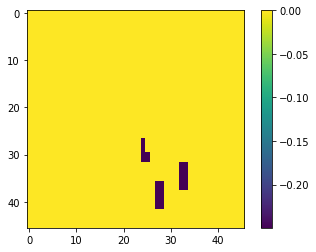

In [69]:
plt.imshow(paf1y.numpy())
plt.colorbar()

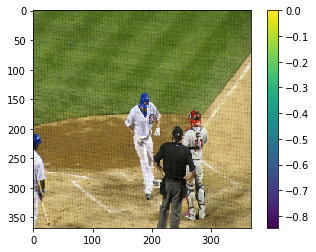

In [49]:

plt.imshow(paf1.numpy())
plt.colorbar()
plt.imshow(st[0][0])
plt.show()